### Setup & Imports

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/Kannada-MNIST/test.csv
/kaggle/input/Kannada-MNIST/Dig-MNIST.csv
/kaggle/input/Kannada-MNIST/sample_submission.csv
/kaggle/input/Kannada-MNIST/train.csv


In [2]:
path = '../input/Kannada-MNIST/'

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [4]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix

In [5]:
from keras.utils import to_categorical

from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

from keras.optimizers import RMSprop

from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


### Data loading & inspection

##### helper functions

In [6]:
"""
helper function to show a number of randomly selected images 
belonging either to a specified label or selected across all labels
"""

def show_random_images(images, num=10, label=None):

    # generating images' subsample if label specified
    if label is not None:
        images = images[images.label == label]
    
    fig, axs = plt.subplots(num, figsize=(1.25, num * 2.5))
    
    for i in range(num):
    
        rnd = np.random.randint(len(images))
    
        # getting image data and splitting between label and pixels' vector
        img_data = np.array(images.iloc[rnd], dtype='uint8')    
        img_label = img_data[0]
        img_pixels = img_data[1:]
        
        # reshaping image to 2D array
        img_shape = (int(np.sqrt(img_pixels.shape[0])), int(np.sqrt(img_pixels.shape[0])))
        img_array = img_pixels.reshape(img_shape)
        
        title = 'Image {} / labelled {}'.format(rnd, img_label)
        
        axs[i].imshow(img_array, alpha=0.66, cmap='gray')
        axs[i].set_title(title)

#### "train.csv"

In [7]:
train_data = pd.read_csv(path + 'train.csv')
train_data

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# checking labels distribution

train_data.label.value_counts()

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: label, dtype: int64

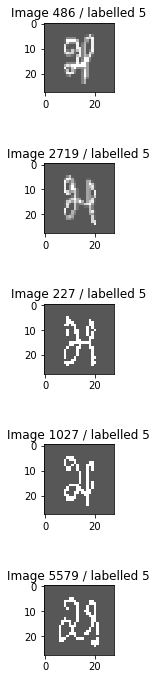

In [9]:
show_random_images(train_data, num=5, label=5)

#### "Dig-MNIST.csv"

In [10]:
dig_data = pd.read_csv(path + 'Dig-MNIST.csv')
dig_data

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10235,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10236,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10237,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10238,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# checking labels distribution

dig_data.label.value_counts()

7    1024
6    1024
5    1024
4    1024
3    1024
2    1024
9    1024
1    1024
8    1024
0    1024
Name: label, dtype: int64

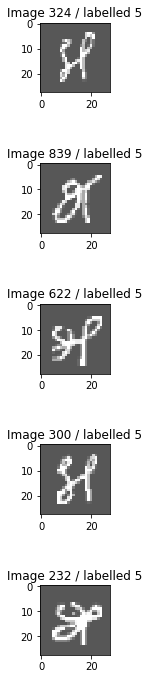

In [12]:
show_random_images(dig_data, num=5, label=5)

### Data preparation

##### Helper functions

In [13]:
# helper function to show randomly selected image from 2D images array

def show_random_image(imgset):
    
    rnd = np.random.randint(imgset.shape[0])
    imgarray = imgset[rnd,:,:,0]
    plt.figure(figsize=(1.5, 1.5))
    plt.imshow(imgarray, cmap='gray')

#### Preparing "train" images

In [14]:
# preparing train image labels using 'one-hot' encoding

train_labels = to_categorical(train_data.label)
train_labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [15]:
train_labels.shape

(60000, 10)

In [16]:
# preparing train images array ('flat' image vectors)

train_images = np.array(train_data.drop(columns='label'))
train_images.shape

(60000, 784)

In [17]:
# preparing 2D train images array (reshaping original 'flat' image vectors array)

n_images = train_images.shape[0]
dim = int(np.sqrt(train_images.shape[1]))

train_images_2D = train_images.reshape(n_images, dim, dim, 1)
train_images_2D.shape

(60000, 28, 28, 1)

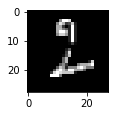

In [18]:
show_random_image(train_images_2D)

In [19]:
# normalizing "train" images

train_images_2D = train_images_2D.astype('float')
train_images_2D /= 255

#### Preparing "Dig-MNIST" images

In [20]:
# preparing dig-mnist image labels using 'one-hot' encoding

dig_labels = to_categorical(dig_data.label)
dig_labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [21]:
dig_labels.shape

(10240, 10)

In [22]:
# preparing train images array ('flat' image vectors)

dig_images = np.array(dig_data.drop(columns='label'))
dig_images.shape

(10240, 784)

In [23]:
# preparing 2D dig-mnist images array (reshaping original 'flat' image vectors array)

n_images = dig_images.shape[0]
dim = int(np.sqrt(dig_images.shape[1]))

dig_images_2D = dig_images.reshape(n_images, dim, dim, 1)
dig_images_2D.shape

(10240, 28, 28, 1)

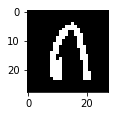

In [24]:
show_random_image(dig_images_2D)

In [25]:
# normalizing "Dig-MNIST" images

dig_images_2D = dig_images_2D.astype('float')
dig_images_2D /= 255

### Modelling

#### splitting "train_images_2D" between train/validation subsets

In [26]:
images_train,images_val,labels_train,labels_val = train_test_split(train_images_2D, train_labels, 
                                                                   random_state=42,test_size=0.15)

#### Train images augmentation
source: https://www.kaggle.com/shahules/indian-way-to-learn-cnn

In [27]:
# fitting ImageDataGenerator on "images_train" subset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(images_train)

#### Setting (hyper)parameters

In [28]:
# setting input dimensionality - 2D image arrays

input_shape = (dim, dim, 1)
num_classes = 10

In [29]:
# setting optimization parameters

optimizer = RMSprop(lr=0.001)
loss = 'categorical_crossentropy'
metrics = ['accuracy']

In [30]:
# setting training parameters

epochs = 100
batch_size = 1024

# setting early stopping callback
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0, 
                           patience=10, 
                           verbose=1, 
                           mode='auto', 
                           baseline=None, 
                           restore_best_weights=False)

# setting learnig rate reduction callback
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                 patience=3, 
                                 verbose=1, 
                                 factor=0.5, 
                                 min_lr=0.00001)

callbacks = [lr_reduction, early_stop]

In [31]:
# defining model's architecture 
# version from 2019_12_12_Kannada_CNN with augmentation version 4 (the best so far)

kernel_size_1 = (7, 7)
kernel_size_2 = (5, 5)

model = Sequential()

model.add(Conv2D(32, kernel_size=kernel_size_1, activation='relu', padding='same', 
                 input_shape=input_shape))
model.add(Conv2D(32, kernel_size=kernel_size_1, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=kernel_size_2, activation='relu', padding='same'))
model.add(Conv2D(64, kernel_size=kernel_size_2, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

In [32]:
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        1600      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        50208     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        102464    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)         

In [34]:
model.fit_generator(datagen.flow(images_train, labels_train, 
                                 batch_size=batch_size), 
                    epochs=epochs, 
                    verbose=True, 
                    callbacks=callbacks, 
                    validation_data=(images_val, labels_val))

Epoch 1/100
50/50 [==============================] - 16s 324ms/step - loss: 0.9523 - accuracy: 0.6741 - val_loss: 0.1001 - val_accuracy: 0.9680
Epoch 2/100
50/50 [==============================] - 13s 257ms/step - loss: 0.2549 - accuracy: 0.9245 - val_loss: 0.0624 - val_accuracy: 0.9813
Epoch 3/100
50/50 [==============================] - 13s 263ms/step - loss: 0.1401 - accuracy: 0.9591 - val_loss: 0.0578 - val_accuracy: 0.9821
Epoch 4/100
50/50 [==============================] - 12s 248ms/step - loss: 0.0962 - accuracy: 0.9723 - val_loss: 0.0399 - val_accuracy: 0.9881
Epoch 5/100
50/50 [==============================] - 13s 258ms/step - loss: 0.0763 - accuracy: 0.9779 - val_loss: 0.0271 - val_accuracy: 0.9918
Epoch 6/100
50/50 [==============================] - 12s 249ms/step - loss: 0.0588 - accuracy: 0.9837 - val_loss: 0.0235 - val_accuracy: 0.9926
Epoch 7/100
50/50 [==============================] - 14s 274ms/step - loss: 0.0476 - accuracy: 0.9857 - val_loss: 0.0240 - val_accuracy:

#### Learning history

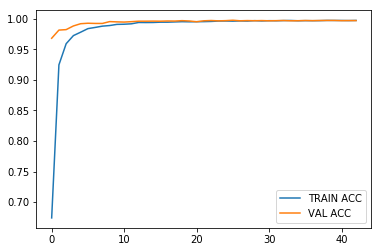

In [35]:
# showing history of 'accuracy'

plt.figure()
plt.plot(model.history.history['accuracy'], label='TRAIN ACC')
plt.plot(model.history.history['val_accuracy'], label='VAL ACC')
plt.legend()
plt.show()

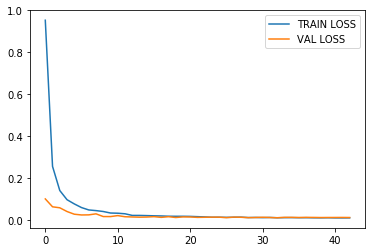

In [36]:
# showing history of 'loss'

plt.figure()
plt.plot(model.history.history['loss'], label='TRAIN LOSS')
plt.plot(model.history.history['val_loss'], label='VAL LOSS')
plt.legend()
plt.show()

#### Model evaluation on "train" data

In [37]:
# making predictions for "train" data (in-sample check)

pred_train = model.predict_classes(train_images_2D)
pred_train.shape

(60000,)

In [38]:
hits = (pred_train == train_data.label)
print('Hits: {}, i.e. {:.2f}%'.format(hits.sum(), hits.sum() / pred_train.shape[0] * 100))

Hits: 59912, i.e. 99.85%


In [39]:
miss = (pred_train != train_data.label)
print('Misses: {}, i.e. {:.2f}%'.format(miss.sum(), miss.sum() / pred_train.shape[0] * 100))

Misses: 88, i.e. 0.15%


In [40]:
cm = confusion_matrix(y_true=train_data.label, y_pred=pred_train)
cm = pd.DataFrame(cm, index=range(num_classes), columns=range(num_classes))
cm

,0,1,2,3,4,5,6,7,8,9
0,5972,28,0,0,0,0,0,0,0,0
1,3,5997,0,0,0,0,0,0,0,0
2,6,0,5994,0,0,0,0,0,0,0
3,0,0,0,5989,1,0,0,10,0,0
4,0,0,0,0,5999,0,0,0,0,1
5,0,0,0,0,1,5999,0,0,0,0
6,0,0,0,1,0,0,5979,10,0,10
7,0,0,0,3,0,0,3,5994,0,0
8,0,0,0,0,0,0,0,0,6000,0
9,0,0,0,0,0,0,10,0,1,5989


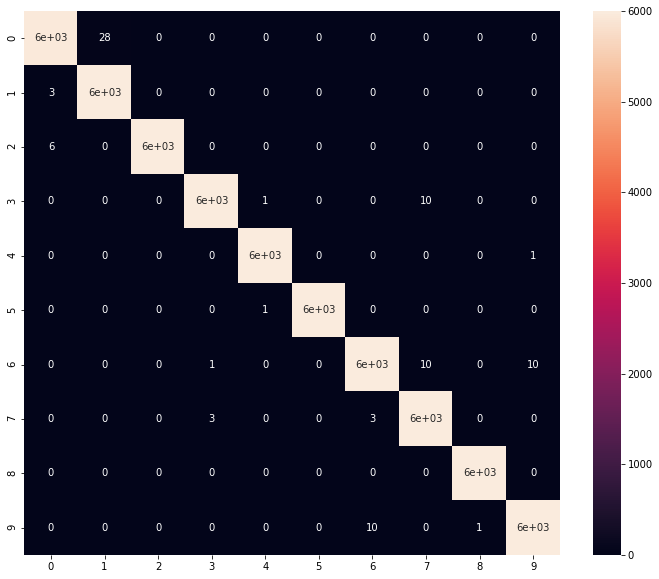

In [41]:
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True,)

In [42]:
# evaluating model on "train" data

eval_metrics = model.evaluate(x=train_images_2D, y=train_labels, 
                              batch_size=batch_size, verbose=True, callbacks=callbacks)
pd.DataFrame(eval_metrics, index=model.metrics_names, columns=['metric'])

60000/60000 [==============================] - 1s 25us/step


,metric
loss,0.004673
accuracy,0.998533


#### Model evaluation on "Dig-MNIST" data

In [43]:
# making predictions for "Dig-MNIST" data

pred_Dig = model.predict_classes(dig_images_2D)
pred_Dig.shape

(10240,)

In [44]:
hits = (pred_Dig == dig_data.label)
print('Hits: {}, i.e. {:.2f}%'.format(hits.sum(), hits.sum() / pred_Dig.shape[0] * 100))

Hits: 8984, i.e. 87.73%


In [45]:
miss = (pred_Dig != dig_data.label)
print('Misses: {}, i.e. {:.2f}%'.format(miss.sum(), miss.sum() / pred_Dig.shape[0] * 100))

Misses: 1256, i.e. 12.27%


In [46]:
cm = confusion_matrix(y_true=dig_data.label, y_pred=pred_Dig)
cm = pd.DataFrame(cm, index=range(num_classes), columns=range(num_classes))
cm

,0,1,2,3,4,5,6,7,8,9
0,839,43,17,10,1,19,0,3,9,83
1,78,872,21,5,4,14,0,21,1,8
2,12,6,963,9,3,22,0,4,4,1
3,6,1,31,867,1,76,2,39,1,0
4,1,3,27,0,948,14,7,2,8,14
5,0,1,2,1,8,1003,0,1,8,0
6,0,4,22,9,41,36,787,68,4,53
7,2,4,25,3,0,22,137,826,1,4
8,1,7,13,2,3,11,18,2,946,21
9,0,11,2,1,1,2,54,2,18,933


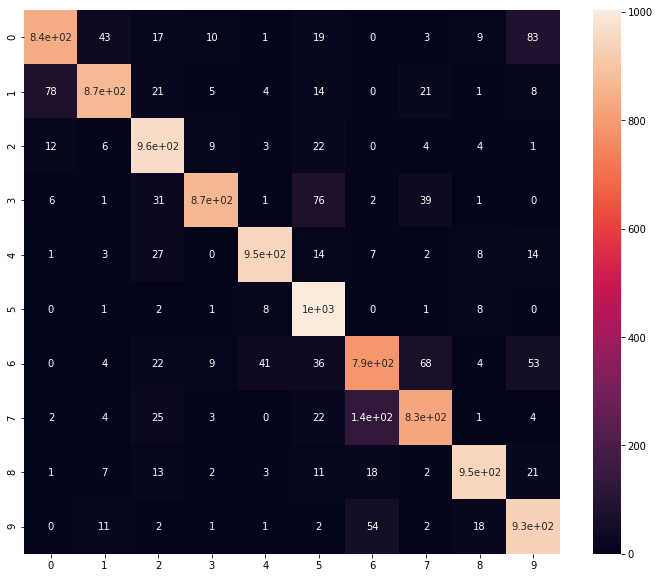

In [47]:
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True,)

In [48]:
# evaluating model on "Dig-MNIST" data

eval_metrics = model.evaluate(x=dig_images_2D, y=dig_labels, 
                              batch_size=batch_size, verbose=True, callbacks=callbacks)
pd.DataFrame(eval_metrics, index=model.metrics_names, columns=['metric'])

10240/10240 [==============================] - 0s 27us/step


,metric
loss,0.796527
accuracy,0.877344


### Predicting

#### Loading test images and sample submission

In [49]:
test_data = pd.read_csv(path + 'test.csv', index_col='id')
test_data

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
submission = pd.read_csv(path + 'sample_submission.csv', index_col='id')
submission

,label
id,
0,5
1,5
2,5
3,5
4,5
...,...
4995,5
4996,5
4997,5


#### Preparing test images

In [51]:
# preparing test images array ('flat' image vectors)

test_images = np.array(test_data)
test_images.shape

(5000, 784)

In [52]:
# preparing 2D test images array (reshaping original 'flat' image vectors array)

n_images = test_images.shape[0]
dim = int(np.sqrt(train_images.shape[1]))

test_images_2D = test_images.reshape(n_images, dim, dim, 1)
test_images_2D.shape

(5000, 28, 28, 1)

In [53]:
# normalizing "test" images

test_images_2D = test_images_2D.astype('float')
test_images_2D /= 255

#### Re-training model with optimized parameters

In [54]:
# re-setting model
optimizer = RMSprop(lr=0.001)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [55]:
# fitting ImageDataGenerator on full train dataset ("train_images_2D")

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(train_images_2D)

In [56]:
# setting learnig rate reduction callback
lr_reduction = ReduceLROnPlateau(monitor='accuracy', 
                                 patience=3, 
                                 verbose=1, 
                                 factor=0.5, 
                                 min_lr=0.00001)

callbacks = [lr_reduction]

In [57]:
# setting the optimal number of epochs
epochs = early_stop.stopped_epoch + 1

# re-training the model on full train dataset
model.fit_generator(datagen.flow(train_images_2D, train_labels, 
                                 batch_size=batch_size), 
                    epochs=epochs, 
                    verbose=True, 
                    callbacks=callbacks)

Epoch 1/43
59/59 [==============================] - 18s 298ms/step - loss: 0.0337 - accuracy: 0.9917
Epoch 2/43
59/59 [==============================] - 17s 284ms/step - loss: 0.0214 - accuracy: 0.9938
Epoch 3/43
59/59 [==============================] - 16s 279ms/step - loss: 0.0195 - accuracy: 0.9945
Epoch 4/43
59/59 [==============================] - 17s 286ms/step - loss: 0.0187 - accuracy: 0.9947
Epoch 5/43
59/59 [==============================] - 17s 284ms/step - loss: 0.0182 - accuracy: 0.9947
Epoch 6/43
59/59 [==============================] - 17s 282ms/step - loss: 0.0175 - accuracy: 0.9949
Epoch 7/43
59/59 [==============================] - 17s 281ms/step - loss: 0.0172 - accuracy: 0.9948
Epoch 8/43
59/59 [==============================] - 17s 294ms/step - loss: 0.0168 - accuracy: 0.9948
Epoch 9/43
59/59 [==============================] - 17s 286ms/step - loss: 0.0176 - accuracy: 0.9949

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 10/4

#### Generating predictions

In [58]:
# making predictions on "test" data

pred_test = model.predict_classes(test_images_2D)

In [59]:
submission.label = pred_test
submission.to_csv('submission.csv')